In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [360]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier

In [361]:
import warnings 
warnings.filterwarnings('ignore')

# Задача кредитного скоринга

https://www.kaggle.com/competitions/sf-dst-scoring

## Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [362]:
train = pd.read_csv(r"D:\Курсы\train.csv")

In [363]:
test = pd.read_csv(r"D:\Курсы\test.csv")

In [364]:
train.shape

(73799, 19)

In [365]:
train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [366]:
train.dtypes

client_id             int64
app_date             object
education            object
sex                  object
age                   int64
car                  object
car_type             object
decline_app_cnt       int64
good_work             int64
score_bki           float64
bki_request_cnt       int64
region_rating         int64
home_address          int64
work_address          int64
income                int64
sna                   int64
first_time            int64
foreign_passport     object
default               int64
dtype: object

# Проверим дубликаты в строках

In [367]:
train[train.duplicated()]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default


В строках нет полных дубликатов

# Посмотрим распределение default столбца

0.127


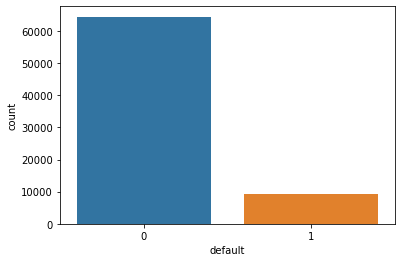

In [368]:
sns.countplot(x=train.default)
print(round(train.default.sum()/train.default.count(), 3))

По данным понятно, что 12.7% людей не возвращают кредит

# Посмотрим в каких столбцах есть null-значения

In [369]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [370]:
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

По данным можно понять, что в столбце education есть null-значения

# Заполним null-значения

### Разобьем выборку на две: в которых есть null-значения и в которых их нет

Это необходимо для того, чтобы понять, как влияют null-значения на целевую переменную

In [371]:
train_with_null = train
train_without_null = train.dropna().reset_index()

In [372]:
round(train_with_null.default.sum()/train_with_null.default.count(), 5)

0.12699

In [373]:
round(train_without_null.default.sum()/train_without_null.default.count(), 5)

0.12705

Как мы можем увидеть, null-значения не сильно влияют на столбец default, поэтому их можно удалить

In [374]:
train.dropna(inplace=True)

# Удалим все уникальный значения

In [375]:
train.nunique()

client_id           73492
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           68808
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                965
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

Удалим из таблицы client_id и score_bki

In [376]:
train.drop(['client_id'], axis=1, inplace=True)

# Проверим зависимость некоторых столбцов на столбец default 

Введем дополнительные функции

In [377]:
def print_data_percent(train, column):           #Фукнция, чтобы вычислить процентное соотношение
    for col in train['{}'.format(column)].unique():
        data = train.loc[train['{}'.format(column)] == col]
        print('{}: {:.3f}'.format(col, sum(data['default'])/len(data)))

In [378]:
def countplot_data(column):
    sns.countplot(x=train['default'], hue=column, data=train)

In [379]:
def print_data_count_in_percent(train, column):
    for col in train['{}'.format(column)].unique():
        data = train[train[f'{column}'] == col]
        print('{}: {:.3f}'.format(col, len(data)/len(train)))

### Преобразуем столбец app_date из строки в дату

In [380]:
train.app_date = pd.to_datetime(train.app_date, format='%d%b%Y')
test.app_date = pd.to_datetime(test.app_date, format='%d%b%Y')

train.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


### Зависимость возраста и default

<AxesSubplot:xlabel='age', ylabel='Count'>

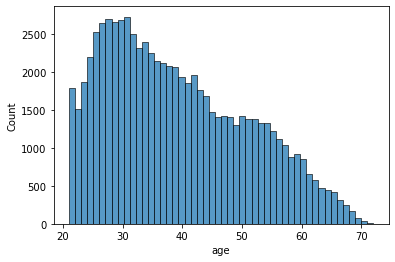

In [381]:
sns.histplot(train.age, bins=50)

Признак age не имеет нормального распределения, но по граифку видно, что люди в 25-32 чаще всего берут кредит

Можно разбить возраст на промежутки и проверить взаимосвязь с целевым признаком

In [382]:
train['age_intervals'] = pd.qcut(train.age, 10)

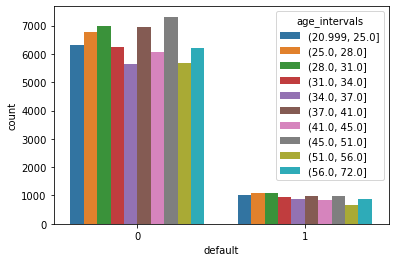

In [383]:
countplot_data(train.age_intervals)

In [384]:
print_data_percent(train, 'age_intervals')

(56.0, 72.0]: 0.122
(20.999, 25.0]: 0.139
(51.0, 56.0]: 0.106
(45.0, 51.0]: 0.120
(25.0, 28.0]: 0.140
(37.0, 41.0]: 0.122
(28.0, 31.0]: 0.135
(31.0, 34.0]: 0.130
(34.0, 37.0]: 0.133
(41.0, 45.0]: 0.120


Чаще всего люди, чей возраст в диапазоне [21, 25] и [25.28] не отдают кредит, а реже в [51, 56]

###  Зависимость default и education

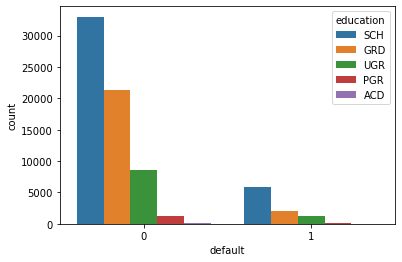

In [385]:
countplot_data(train.education)

In [386]:
print_data_count_in_percent(train, 'education')

SCH: 0.529
GRD: 0.318
UGR: 0.134
PGR: 0.017
ACD: 0.003


In [387]:
print_data_percent(train, 'education')

SCH: 0.151
GRD: 0.090
UGR: 0.132
PGR: 0.064
ACD: 0.041


Исходя из этих данных, можно понять, что люди с уровнями SCH и UGR (15.1% и 13.2% соответственно) чаще всего не отдают кредит

Также можно понять, что люди с уровнями PGR и ACD (6.4% и 4.1% соответсвенно) реже всего не отдавали кредит

###  Зависимость default и sex

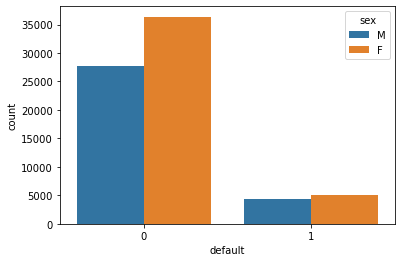

In [388]:
countplot_data(train.sex)

In [389]:
print_data_percent(train, 'sex')

M: 0.135
F: 0.121


In [390]:
print_data_count_in_percent(train, 'sex')

M: 0.437
F: 0.563


По этим данным можно понять, что женщины чаще брали кредит, но мужчины реже их отдавали

### Зависимость default и car

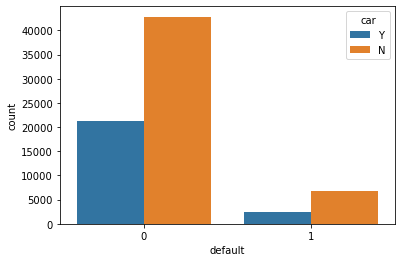

In [391]:
countplot_data(train.car)

In [392]:
print_data_count_in_percent(train, 'car')

Y: 0.324
N: 0.676


In [393]:
print_data_percent(train, 'car')

Y: 0.106
N: 0.137


Люди без машин чаще берут кредит и реже его отдают

### Зависимость car_type и default

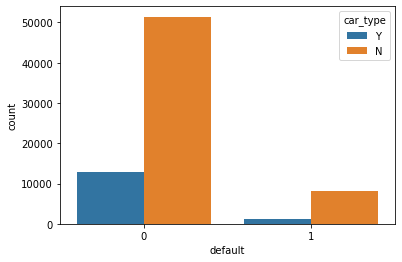

In [394]:
countplot_data(train.car_type)

In [395]:
print_data_count_in_percent(train, 'car_type')

Y: 0.190
N: 0.810


In [396]:
print_data_percent(train, 'car_type')

Y: 0.088
N: 0.136


### Зависимость good_work и default

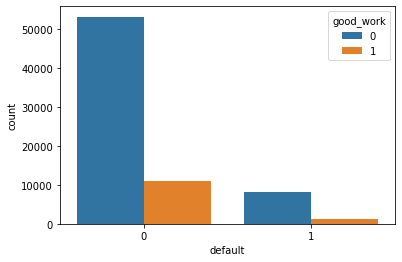

In [397]:
countplot_data(train.good_work)

In [398]:
print_data_count_in_percent(train, 'good_work')

0: 0.835
1: 0.165


In [399]:
print_data_percent(train, 'car_type')

Y: 0.088
N: 0.136


Также можно заметить, что люди с "хорошей" работой реже берут кредит и чаще его отдают, чем люди с "плохой"

### Зависимость foreign_passport и default

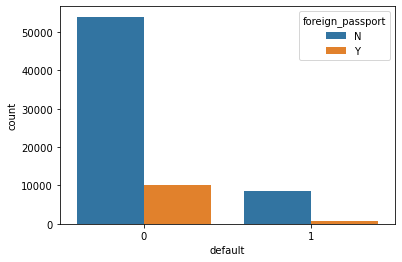

In [400]:
countplot_data(train.foreign_passport)

In [401]:
print_data_count_in_percent(train, 'foreign_passport')

N: 0.850
Y: 0.150


In [402]:
print_data_percent(train, 'good_work')

0: 0.134
1: 0.094


Как и с предыдущими рассматриваемыми признаками, можно заметить, что люди без загранпаспорта чаще берут кредит и реже отдают

# Добавление дополнительных столбцов

#### Как вляет месяц на частоту взятия кредита?


In [403]:
train['month'] = train['app_date'].dt.month

In [404]:
test['month'] = test['app_date'].dt.month

In [405]:
train.month.unique()

array([2, 3, 1, 4], dtype=int64)

In [406]:
train['app_date']

0       2014-02-01
1       2014-03-12
2       2014-02-01
3       2014-01-23
4       2014-04-18
           ...    
73794   2014-03-04
73795   2014-03-24
73796   2014-04-22
73797   2014-01-04
73798   2014-01-23
Name: app_date, Length: 73492, dtype: datetime64[ns]

Можно понять, что в нашей выборке есть данные о четырех месяцах

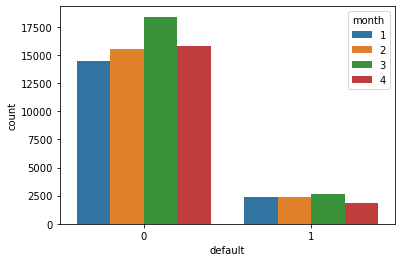

In [407]:
countplot_data(train.month)

In [408]:
print_data_count_in_percent(train, 'month')

2: 0.244
3: 0.287
1: 0.229
4: 0.240


In [409]:
print_data_percent(train, 'month')

2: 0.133
3: 0.128
1: 0.142
4: 0.106


По данным можно понять, что чаще всего брали кредит в марте, а реже всего в январе, но в январе реже всего отдавали кредит

#### Если адрес клиента совпадает с адресом банка, то как они вместе влияют на целевую переменную?

In [410]:
train['work_home_address_equals'] = train['work_address'] == train['home_address']
train['work_home_address_equals'].unique()

array([False,  True])

In [411]:
test['work_home_address_equals'] = test['work_address'] == test['home_address']
test['work_home_address_equals'].unique()

array([False,  True])

In [412]:
train['work_address'].corr(train['home_address'])

0.7283371294553926

Сильная корреляция, можно объединить в один признак и удалить столбцы home_address, work_address

In [413]:
train['work_home_address_equals'] = train['work_home_address_equals'].replace({True: 1, False: 0})
test['work_home_address_equals'] = test['work_home_address_equals'].replace({True: 1, False: 0})

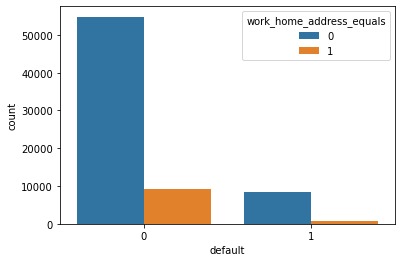

In [414]:
countplot_data(train.work_home_address_equals)

In [415]:
print_data_count_in_percent(train, 'work_home_address_equals')

0: 0.861
1: 0.139


In [416]:
print_data_percent(train, 'work_home_address_equals')

0: 0.134
1: 0.084


print_data_percent(train, 'work_home_address_equals')

Как мы видим, всего у 14% людей адрес банка совпадаем с адресом клиента

Эти люди чаще отдают кредит

Удалим признаки home_address и work_address

In [417]:
train.drop(['home_address','work_address'], inplace = True, axis = 1)
test.drop(['home_address','work_address'], inplace = True, axis = 1)

#### Какая корреляции у car и car_type?

In [418]:
label_encoder = LabelEncoder()
train['car'] = label_encoder.fit_transform(train['car'])
train['car_type'] = label_encoder.fit_transform(train['car_type'])

In [419]:
label_encoder = LabelEncoder()
test['car'] = label_encoder.fit_transform(test['car'])
test['car_type'] = label_encoder.fit_transform(test['car_type'])

In [420]:
train['car'].corr(train['car_type'])

0.6987980368931292

Между car и car_type сильная корреляция, их в можно объединить в один признак

In [421]:
train['car_and_car_type'] = train['car']+train['car_type']

In [422]:
test['car_and_car_type'] = test['car']+test['car_type']

In [423]:
train['car_and_car_type'] = label_encoder.fit_transform(train['car_and_car_type'])

In [424]:
test['car_and_car_type'] = label_encoder.fit_transform(test['car_and_car_type'])

Удалим признаки car и car_type

In [425]:
train.drop(['car','car_type'], inplace = True, axis = 1)

In [426]:
test.drop(['car','car_type'], inplace = True, axis = 1)

#### Введем дополнительные признаки при помощи groupby

In [427]:
# Средний доход в зависимости от возраста
mean_income = train.groupby('age')['income'].mean().to_dict()
train['mean_income_age'] = train['age'].map(mean_income)

In [428]:
# Среднее количество запросов в БКИ от возраста
mean_bki = train.groupby('age')['bki_request_cnt'].mean().to_dict()
train['mean_requests_age'] = train['age'].map(mean_bki)

In [429]:
# Средний возраст по скоринговому баллу
mean_score_age = train.groupby('score_bki')['age'].mean().to_dict()
train['mean_score_age'] = train['score_bki'].map(mean_score_age)

In [430]:
# Максимальный возраст по скоринговому баллу
max_score_age = train.groupby('score_bki')['age'].max().to_dict()
train['max_score_age'] = train['score_bki'].map(max_score_age)

In [431]:
# Максимальный доход по скоринговому баллу
max_score_income = train.groupby('score_bki')['income'].max().to_dict()
train['max_score_income'] = train['score_bki'].map(max_score_income)

In [432]:
# Максимальный доход по скоринговому баллу
max_score_income = train.groupby('score_bki')['income'].max().to_dict()
train['max_score_income'] = train['score_bki'].map(max_score_income)

In [433]:
# Средний рейтинг региона по скоринговому баллу
mean_score_region_rating = train.groupby('score_bki')['region_rating'].mean().to_dict()
train['mean_score_region_rating'] = train['score_bki'].map(mean_score_region_rating)

<AxesSubplot:>

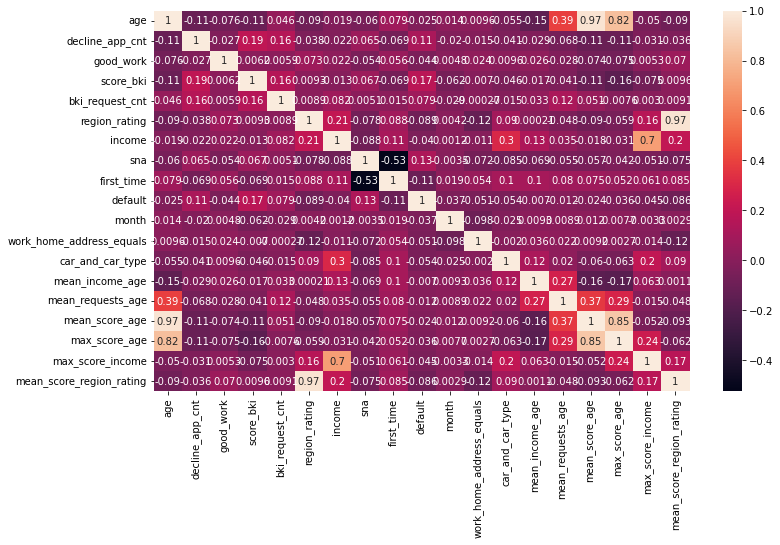

In [434]:
plt.subplots(figsize=(12, 7))
sns.heatmap(train.corr(), annot=True, fmt='.2g')

Как мы видим новые признаки сильно коррелируют с остальными признаками, удалим некоторые из них

In [435]:
train.drop(['max_score_income','max_score_age', 'mean_score_region_rating', 'mean_score_age', 'mean_income_age'], inplace=True, axis=1)

<AxesSubplot:>

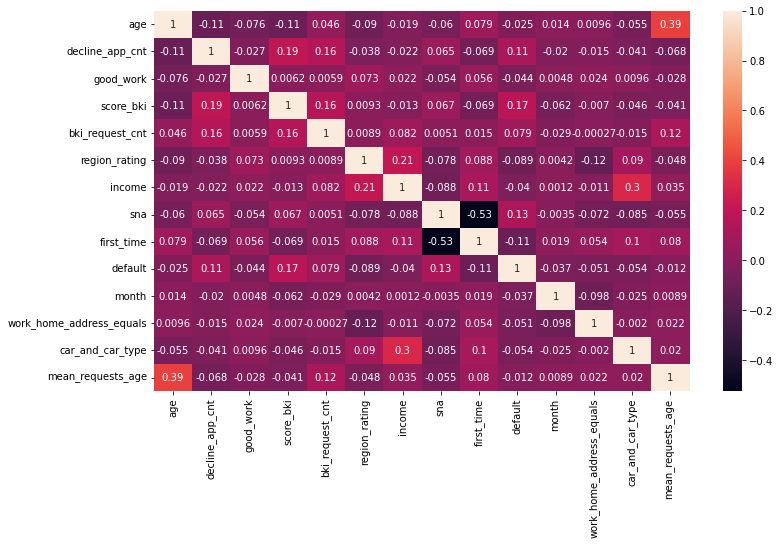

In [436]:
plt.subplots(figsize=(12, 7))
sns.heatmap(train.corr(), annot=True, fmt='.2g')

Признаки first_time(давность наличия информации о заемщике) и sna(связь заемщика с клиентами банка) имеют среднюю отрицательную корреляцию

income и car_and_car_type имеют маленькую корреляцию

А остальные признаки почти не имеют корреляции между собой

# Кодирование и нормирование признаков

In [437]:
label_encoder = LabelEncoder()
train.education = label_encoder.fit_transform(train['education'])
test.education = label_encoder.fit_transform(test['education'])

In [438]:
train.sex = train.sex.replace({'M' : 0, 'F' : 1})
test.sex = test.sex.replace({'M' : 0, 'F' : 1})

In [439]:
train.foreign_passport = train.foreign_passport.replace({'Y' : 1, 'N' : 0})
test.foreign_passport = test.foreign_passport.replace({'Y' : 1, 'N' : 0})

In [440]:
train['region_rating'] = train['region_rating'].apply(lambda x: np.log(x+1))
test['region_rating'] = test['region_rating'].apply(lambda x: np.log(x+1))

In [441]:
train['bki_request_cnt'] = train['bki_request_cnt'].apply(lambda x: np.log(x+1))
test['bki_request_cnt'] = test['bki_request_cnt'].apply(lambda x: np.log(x+1))

In [442]:
train['age'] = train['age'].apply(lambda x: np.log(x+1))
test['age'] = test['age'].apply(lambda x: np.log(x+1))

In [443]:
train['income'] = train['age'].apply(lambda x: np.log(x+1))
test['income'] = test['age'].apply(lambda x: np.log(x+1))

In [444]:
tr = ['app_date', 'age_intervals']
tt = ['client_id', 'app_date']

In [468]:
train.drop(tr, axis=1, inplace=True)

In [469]:
test.drop(tt, axis=1, inplace=True)

# Построение моделей

### Модели на одной фиче

In [445]:
metrics = {'accuracy': accuracy_score,
          'precision': precision_score,
          'recall': recall_score,
          'f1': f1_score}

In [446]:
def check_all_models_by_metrics(clf, metrics):
    y_pred = clf.predict(X_val)
    y_prob = clf.predict_proba(X_val)
    y_prob = y_prob[:, 1]
    print(clf, end=': \n')
    print('\troc_auc - ' + str(round(roc_auc_score(y_val, y_prob),5)))
    for metric in metrics:
        print('\t' + metric + ' - ' + str(round(metrics[metric](y_val, y_pred), 5)))

In [447]:
def check_perceptron_by_metrics(clf, metrics):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf, end=': \n')
    print('\troc_auc - ' + str(round(roc_auc_score(y_val, y_pred),5)))
    for metric in metrics:
        print('\t' + metric + ' - ' + str(round(metrics[metric](y_val, y_pred), 5)))

Попробуем три разные модели: KNeighborsClassifier, LogisticRegression, RandomForest без подбора гиперпараметров

Для этих трех моделей посчитает по пять метрик: f1, accuracy, precision, roc_auc 

In [448]:
X = train[['score_bki']]
y = train[['default']]

In [449]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=42, test_size=0.2)

###  KNeighborsClassifier

In [450]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

KNeighborsClassifier(): 
	roc_auc - 0.55532
	accuracy - 0.85856
	precision - 0.22995
	recall - 0.04582
	f1 - 0.07641


### LogisticRegression

In [451]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

LogisticRegression(): 
	roc_auc - 0.64809
	accuracy - 0.87224
	precision - 0.0
	recall - 0.0
	f1 - 0.0


### RandomForestClassifier

In [452]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

RandomForestClassifier(): 
	roc_auc - 0.55041
	accuracy - 0.7942
	precision - 0.17125
	recall - 0.1593
	f1 - 0.16506


### Perceptron

In [453]:
clf = Perceptron()
clf.fit(X_train, y_train)
check_perceptron_by_metrics(clf, metrics)

Perceptron(): 
	roc_auc - 0.50212
	accuracy - 0.87203
	precision - 0.41667
	recall - 0.00533
	f1 - 0.01052


### Вывод

Исходя из полученных данных, можно сделать вывод, что у всех моделей высокий показатель accuracy и низкий показатели precision, recall, f1

Глядя на метрику roc_auc, можно сделать вывод, что самый высокий показатель у LogisticRegression

### Модели на некоторых фичах

Отберем признаки, которые коррелируют с целевой переменной ( > 0.1 )

In [470]:
r = []
for i in train.columns:
    if train['default'].corr(train[i]) > 0.1:
        r.append(i)
r.remove('default')

In [471]:
X = train[r]
y = train['default']

In [472]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=42, test_size=0.2)

### KNeighborsClassifier

In [473]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

KNeighborsClassifier(): 
	roc_auc - 0.57377
	accuracy - 0.85591
	precision - 0.24307
	recall - 0.06074
	f1 - 0.09719


### LogisticRegression

In [474]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

LogisticRegression(): 
	roc_auc - 0.67605
	accuracy - 0.87156
	precision - 0.37778
	recall - 0.00906
	f1 - 0.01769


### RandomForestClassifier

In [475]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

RandomForestClassifier(): 
	roc_auc - 0.56829
	accuracy - 0.79448
	precision - 0.17647
	recall - 0.16622
	f1 - 0.17119


### Perceptron

In [476]:
clf = Perceptron()
clf.fit(X_train, y_train)
check_perceptron_by_metrics(clf , metrics)

Perceptron(): 
	roc_auc - 0.60425
	accuracy - 0.62535
	precision - 0.18664
	recall - 0.57592
	f1 - 0.28191


### Вывод

Как мы видим, при добавлении новых признаков показатели всех метрик у всех моделей выросли

Ещё можно заметить, что у Perceptron сильно выросли метрики precision, recall, f1

### Модели на всех фичах

In [477]:
X = train.drop('default', axis=1)
y = train['default']

In [478]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=42, test_size=0.2)

### KNeighborsClassifier

In [479]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

KNeighborsClassifier(): 
	roc_auc - 0.58566
	accuracy - 0.85557
	precision - 0.23026
	recall - 0.05594
	f1 - 0.09001


### LogisticRegression

In [480]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf , metrics)

LogisticRegression(): 
	roc_auc - 0.71674
	accuracy - 0.87128
	precision - 0.41573
	recall - 0.01971
	f1 - 0.03764


### RandomForestClassifier

In [481]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
check_all_models_by_metrics(clf, metrics)

RandomForestClassifier(): 
	roc_auc - 0.66957
	accuracy - 0.86992
	precision - 0.30769
	recall - 0.01492
	f1 - 0.02846


### Perceptron

In [482]:
clf = Perceptron()
clf.fit(X_train, y_train)
check_perceptron_by_metrics(clf, metrics)

Perceptron(): 
	roc_auc - 0.55989
	accuracy - 0.84706
	precision - 0.31902
	recall - 0.17421
	f1 - 0.22536


### Вывод

Когда мы использовали все фичи, метрики всех моделей выросли, но у Perceptron упали все метрики, но выросла accuracy, продолжим исследования для него с малым количеством признаков

Логистическая регрессия показала самый лучший результат

# Кросс-валидация моделей

Проведем кросс-валидацию, чтобы отобрать самые эффективные модели

### KNeighborsClassifier

In [483]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.85491964, 0.85823624, 0.85372906, 0.85711856, 0.85958496])

### Logistic regression

In [484]:
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.87345863, 0.87201293, 0.87243813, 0.87200204, 0.87293757])

### RandomForestClassifier

In [485]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.87235309, 0.87107747, 0.87039714, 0.87055622, 0.8717469 ])

### Perceptron

In [486]:
clf = Perceptron()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.87311846, 0.5750489 , 0.87192789, 0.85881953, 0.85295118])

### Вывод

После проведения кросс-валидации понятно, что все модели показывают примерно одинаковые результаты, за исключением перцептрона, у него на последней валидации отмечается наихудший результат

# Проведем подбор гиперпараметров

Возьмем две модели, которые показали наилучшие результаты на прошлых тестах и подберем гиперпараметры: LogisticRegression и RandomForestClassifier

### Logistic regression

In [487]:
hyperparams = {'penalty': ['l1', 'l2', 'elasticnet'],
              'solver': ['newton-cg', 'newton-cholesky']}

logistic_model = LogisticRegression(random_state=42, max_iter=1000)

clf = GridSearchCV(logistic_model, hyperparams, cv=5)

best_model = clf.fit(X_train, y_train)

best_model.best_params_

{'penalty': 'l2', 'solver': 'newton-cg'}

In [488]:
check_all_models_by_metrics(best_model, metrics)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'newton-cholesky']}): 
	roc_auc - 0.71668
	accuracy - 0.87128
	precision - 0.41573
	recall - 0.01971
	f1 - 0.03764


### RandomForestClassifier

In [489]:
hyperparams = {
    'n_estimators' : [50,100,300],
    'max_depth': [1, 5, 10],
}

random_forest_model = RandomForestClassifier()

clf = GridSearchCV(random_forest_model, hyperparams, cv=5)

best_model = clf.fit(X_train, y_train)

best_model.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [490]:
check_all_models_by_metrics(best_model, metrics)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [50, 100, 300]}): 
	roc_auc - 0.70863
	accuracy - 0.87237
	precision - 0.6
	recall - 0.0016
	f1 - 0.00319


### Вывод

После кросс-валидации трех моделей, можно сделать вывод, что лучше всего отработали модели LogisticRegression(0.72) и RandomForestClassifier(0.71)

Модель RandomForestClassifier после подбора гиперпараметров улучшила свою предсказательную способность: 0.67 -> 0.71

В свою очередь, предсказательная способность LogisticRegression, после проведения кросс-валидации не изменилась